#### Import

In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from __future__ import annotations

import os
import json
import sys
from dataclasses import dataclass, field
from pathlib import Path
from typing import List, Optional
import matplotlib.pyplot as plt
import types
from collections import defaultdict

import mediapy as media
import numpy as np
import torch
import tyro
from rich.console import Console
from rich.progress import (
    BarColumn,
    Progress,
    TaskProgressColumn,
    TextColumn,
    TimeRemainingColumn,
)
from typing_extensions import Literal, assert_never

from nerfstudio.cameras.camera_paths import get_path_from_json, get_spiral_path
from nerfstudio.cameras.cameras import Cameras
from nerfstudio.configs.base_config import Config  # pylint: disable=unused-import
from nerfstudio.pipelines.base_pipeline import Pipeline
from nerfstudio.utils import install_checks
from nerfstudio.utils.eval_utils import eval_setup
from nerfstudio.utils.rich_utils import ItersPerSecColumn
from nerfstudio.field_components.field_heads import FieldHeadNames

from visualization import visualize, visualize_gt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Configs

In [2]:
cwd = "/cluster/angmar/hli"
config_path = "outputs/mono-scannet/0/monosdf/2023-08-05_151338/config.yml"
config_path = "outputs/mono-scannet/3/monosdf/2023-08-05_151338/config.yml"
val_image_id =0

#### Setup

In [3]:
os.chdir(cwd)
_, pipeline, _ = eval_setup(Path(config_path), test_mode="test")

Output()

Output()

Setting up training dataset...

Caching all 465 images.

Output()

Setting up evaluation dataset...

Caching all 465 images.

Output()

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/mono-scannet/3/monosdf/2023-08-05_151338/sdfstudio_models/step-000199999.ckpt

In [4]:
@torch.no_grad()
def get_outputs_for_camera_ray_bundle(self, camera_ray_bundle: RayBundle) -> Dict[str, torch.Tensor]:
    """Takes in camera parameters and computes the output of the model.

    Args:
        camera_ray_bundle: ray bundle to calculate outputs over
    """
    num_rays_per_chunk = self.config.eval_num_rays_per_chunk
    image_height, image_width = camera_ray_bundle.origins.shape[:2]
    num_rays = len(camera_ray_bundle)
    outputs_lists = defaultdict(list)
    for i in range(0, num_rays, num_rays_per_chunk):
        start_idx = i
        end_idx = i + num_rays_per_chunk
        ray_bundle = camera_ray_bundle.get_row_major_sliced_ray_bundle(start_idx, end_idx)
        outputs = self.forward(ray_bundle=ray_bundle)

        # if self.collider is not None:
        #     ray_bundle = self.collider(ray_bundle)
        # samples_and_field_outputs = self.sample_and_forward_field(ray_bundle=ray_bundle)
        
        for output_name, output in outputs.items():  # type: ignore
            outputs_lists[output_name].append(output)
    outputs = {}
    for output_name, outputs_list in outputs_lists.items():
        if not torch.is_tensor(outputs_list[0]):
            # TODO: handle lists of tensors as well
            continue
        outputs[output_name] = torch.cat(outputs_list).view(image_height, image_width, -1)  # type: ignore
    return outputs

@torch.no_grad()
def get_ray_output_for_one_pixel(self, camera_ray_bundle: RayBundle, x:int, y:int) -> Dict[str, torch.Tensor]:
    image_height, image_width = camera_ray_bundle.origins.shape[:2]
    index = image_width * y + x
    ray_bundle = camera_ray_bundle.get_row_major_sliced_ray_bundle(index, index+1)
    outputs = self.forward(ray_bundle=ray_bundle)
    if self.collider is not None:
        ray_bundle = self.collider(ray_bundle)
    samples_and_field_outputs = self.sample_and_forward_field(ray_bundle=ray_bundle)
    outputs.update(samples_and_field_outputs)
    return outputs

pipeline.model.get_outputs_for_camera_ray_bundle_hack = types.MethodType(get_outputs_for_camera_ray_bundle, pipeline.model)
pipeline.model.get_ray_output_for_one_pixel = types.MethodType(get_ray_output_for_one_pixel, pipeline.model)

In [5]:
cameras = pipeline.datamanager.eval_dataloader.get_camera(image_idx=val_image_id).flatten()
camera_ray_bundle = cameras.generate_rays(camera_indices=0)
with torch.no_grad():
    outputs = pipeline.model.get_outputs_for_camera_ray_bundle(camera_ray_bundle)

#### Visualize

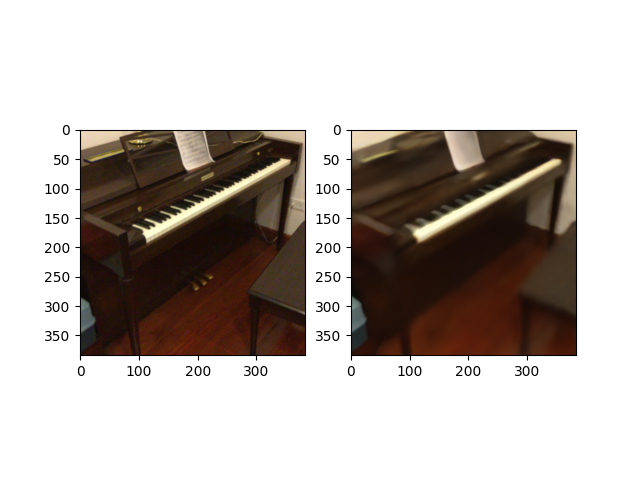

In [6]:
gt_image = pipeline.datamanager.eval_dataloader.input_dataset.get_image(image_idx=val_image_id)
output_image = outputs["rgb"].cpu().numpy()
fig, axes = plt.subplots(1,2)
axes[0].imshow(gt_image)
axes[1].imshow(output_image)

In [7]:
val_image_id = 0
gt_image = pipeline.datamanager.eval_dataloader.input_dataset.get_image(image_idx=val_image_id)
axes[0].imshow(gt_image)

In [30]:
x = 354
y = 266
ray_output = pipeline.model.get_ray_output_for_one_pixel(camera_ray_bundle, x, y)

In [19]:
ray_output["rgb"]*255

tensor([[69.4905, 55.9080, 37.9707]], device='cuda:0')

In [35]:
image_height, image_width = camera_ray_bundle.origins.shape[:2]
index = image_width * y + x
print(index)
ray_bundle = camera_ray_bundle.get_row_major_sliced_ray_bundle(index, index+1)
print(ray_bundle)
outputs = pipeline.model.forward(ray_bundle=ray_bundle)
if pipeline.model.collider is not None:
    ray_bundle = pipeline.model.collider(ray_bundle)
samples_and_field_outputs = pipeline.model.sample_and_forward_field(ray_bundle=ray_bundle)
# outputs.update(samples_and_field_outputs)

102498
RayBundle(origins=tensor([[0.2018, 0.0632, 0.0791]], device='cuda:0'), directions=tensor([[ 0.2529, -0.7718, -0.5834]], device='cuda:0'), pixel_area=tensor([[2.5543e-06]], device='cuda:0'), directions_norm=tensor([[1.0457]], device='cuda:0'), camera_indices=tensor([[0]], device='cuda:0'), nears=None, fars=None, metadata=None, times=None)


In [37]:
outputs

AABBBoxCollider()

In [36]:
samples_and_field_outputs

{'ray_samples': RaySamples(frustums=Frustums(origins=tensor([[[0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0.2018, 0.0632, 0.0791],
          [0

In [13]:
x = ray_output["ray_samples"].frustums.starts.detach().cpu().numpy().squeeze()
dx = ray_output["ray_samples"].deltas.detach().cpu().numpy().squeeze()
rgb = ray_output["field_outputs"][FieldHeadNames.RGB].detach().cpu().numpy().squeeze()
rgb = np.clip(rgb,0,1)
density = ray_output["field_outputs"][FieldHeadNames.DENSITY].detach().cpu().numpy().squeeze()
sdf = ray_output["field_outputs"][FieldHeadNames.SDF].detach().cpu().numpy().squeeze()
weight = ray_output["weights"].detach().cpu().numpy().squeeze()
alpha = ray_output["ray_samples"].get_alphas(ray_output["field_outputs"][FieldHeadNames.DENSITY]).detach().cpu().numpy().squeeze()
transmittance = ray_output["ray_samples"].get_weights_and_transmittance(ray_output["field_outputs"][FieldHeadNames.DENSITY])[1].detach().cpu().numpy().squeeze()

In [26]:
(rgb * weight[...,None]).sum(0)

array([0.9999998, 0.9999998, 0.8511281], dtype=float32)

interactive(children=(FloatLogSlider(value=0.01942058652639389, description='density_param', max=2.0, min=-6.0…

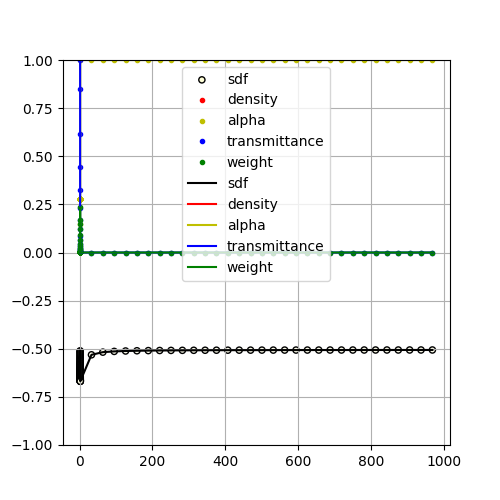

In [21]:
fig, ax = visualize_gt(x,sdf=sdf,rgb=rgb, density=density, weight=weight, alpha = alpha, transmittance = transmittance, line_type='.')
visualize(x = x, dx=dx, sdf = sdf, density_param=pipeline.model.field.laplace_density.get_beta().item(), fig = fig, ax = ax, line_type='-')
_ = ax.set_ylim([-1,1])

In [12]:
# plt.close(fig)